# Read Model VAE from astroml and work with rubinsim

https://www.astroml.org/book_figures/chapter9/fig_sdss_vae.html


- creation 2023-04-24


In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

# Import some generally useful packages

import os,sys
import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

import copy

#from astroML.datasets import sdss_corrected_spectra

# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

/Users/dagoret/anaconda3/envs/fidle23/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
from sklearn.model_selection import train_test_split
import h5py

In [4]:
from rubin_sim.phot_utils import Bandpass, Sed

In [5]:
WL_BALMER_BREAK= 3646.0 

In [6]:
hf = h5py.File('SLspectra.hdf5', 'r') 
data_in = hf['flambda'][:]
wl_in = hf['wl'][:]
target = hf['quantile'][:]

# other data
redshift = hf['redshift'][:]
Rmag = hf['Rmag'][:]
RT = hf['RT'][:]
RV = hf['RV'][:]
ra = hf['ra'][:]
dec = hf['dec'][:]
fracinfbalmer = hf['fracinfbalmer'][:]
number = hf['num'][:]
print(hf.keys())

<KeysViewHDF5 ['Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'flambda', 'fracinfbalmer', 'num', 'quantile', 'ra', 'redshift', 'wl']>


In [7]:
WL = wl_in
NWL = data_in.shape[1]
NSAMPL = data_in.shape[0]

In [8]:
idx_blue = np.where (WL<WL_BALMER_BREAK)[0]
idx_red = np.where (WL>=WL_BALMER_BREAK)[0]
wl_blue = WL[idx_blue]
wl_red = WL[idx_red]

In [9]:
#x_train, x_test, y_train, y_test = train_test_split(data_in,
#                                          target,
#                                          test_size=0.2)

In [10]:
# Fetch and prepare the data
#data = sdss_corrected_spectra.fetch_sdss_corrected_spectra()
#spectra = sdss_corrected_spectra.reconstruct_spectra(data)
#wavelengths = sdss_corrected_spectra.compute_wavelengths(data)

spectra = data_in
wavelengths = wl_in

# normalize spectra by integrated flux and subtract out mean, for easier training
spectranorms = np.mean(spectra, axis=1)
normedspectra = spectra / spectranorms[:, None]
renormedspectra = copy.deepcopy(normedspectra)

#already normalized spectra in prepareData, but it does not work ????
#normedspectra = spectra

meanspectrum = np.mean(normedspectra, axis=0)
normedspectra -= meanspectrum[None, :]

# split data into 3:1 train:test
torch.manual_seed(802)  # seed used for book figure
dataset = torchdata.TensorDataset(torch.tensor(normedspectra))
trainnum = normedspectra.shape[0] // 4 * 3
traindata, testdata = torchdata.random_split(dataset, [trainnum, normedspectra.shape[0] - trainnum])
traindataloader = torchdata.DataLoader(traindata, batch_size=64, shuffle=True)

# Definition of VAE model 

In [11]:
# define structure of variation autoencoder
class VAE(nn.Module):
    def __init__(self, nhidden=250):
        super(VAE, self).__init__()

        self.encode_fc = nn.Linear(NWL, nhidden)
        self.mu        = nn.Linear(nhidden, 2)
        self.logvar    = nn.Linear(nhidden, 2)

        self.decode_fc = nn.Linear(2, nhidden)
        self.output    = nn.Linear(nhidden, NWL)

    def encode(self, x):
        h = F.relu(self.encode_fc(x))
        return self.mu(h), self.logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h = F.relu(self.decode_fc(z))
        return self.output(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



## Read model

In [12]:
#torch.save(model,"modelvae_fromastroml_pytorch_v1.pth")
#torch.save(model.state_dict(),"modelvae_fromastroml_pytorch_v2.pth")

In [13]:
model = VAE()

In [14]:
#model.load_state_dict(torch.load("modelvae_fromastroml_pytorch_v2.pth"))
model.load_state_dict(torch.load("modelvae_fromastroml_pytorch_2latentvariables.pth"))

<All keys matched successfully>

## plot results

### Generate a single spectrum from latent variables

In [15]:
z0 = np.array([0.,0], dtype=np.float32)

In [16]:
label = f"$(z_1,z_2) = $ ({z0[0]}, {z0[1]})"

In [17]:
spectrum = model.decode(torch.tensor(z0))

In [18]:
# if we are not detaching, need no_grad()
#with torch.no_grad():
#    plt.plot(wavelengths, meanspectrum+spectrum.numpy(),'r-')

In [19]:
# here we need to detach to convert the tensor to another tensor that isn't requiring a gradient 
dspectrum = spectrum.detach().numpy()

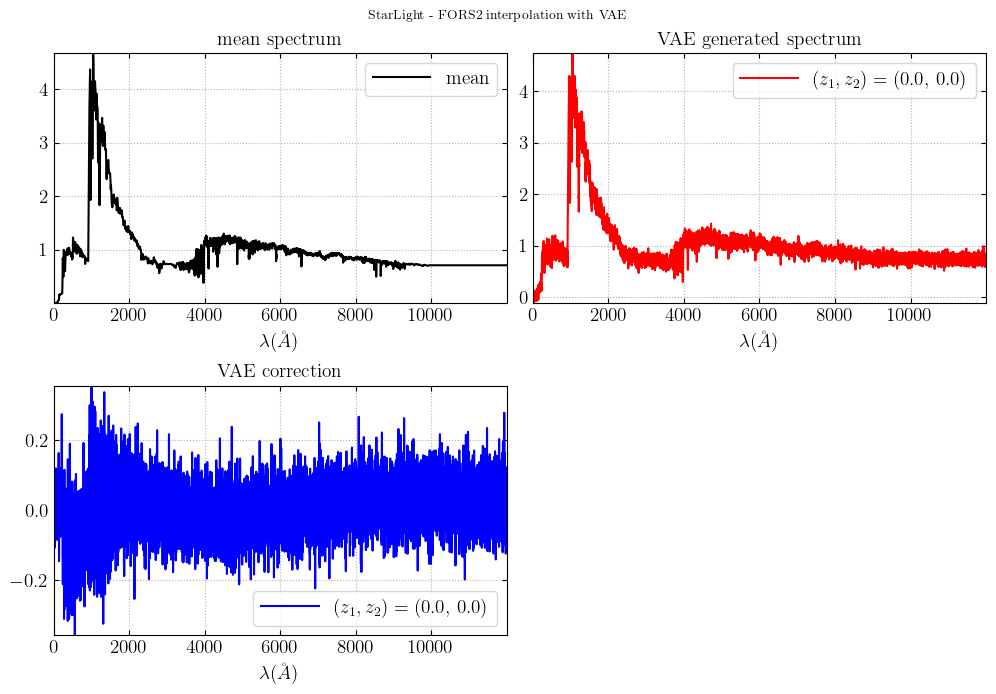

In [20]:
fig=plt.figure(figsize=(10,7))
ax=fig.add_subplot(2,2,1)
ax.plot(wavelengths, meanspectrum,'k-',label="mean")
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("mean spectrum")
ax=fig.add_subplot(2,2,2)
ax.plot(wavelengths, meanspectrum+dspectrum,'r-',label=label)
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("VAE generated spectrum")
ax=fig.add_subplot(2,2,3)
ax.plot(wavelengths, dspectrum,'b-',label=label)
ax.set_xlabel("$\lambda (\AA)$")
ax.grid()
ax.legend()
ax.set_title("VAE correction")

plt.suptitle("StarLight - FORS2 interpolation with VAE")
plt.tight_layout()
plt.show()

### Scan a grid of latent variables

In [21]:
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
#all_colors2 = scalarMap2.to_rgba(all_redshifts, alpha=1)

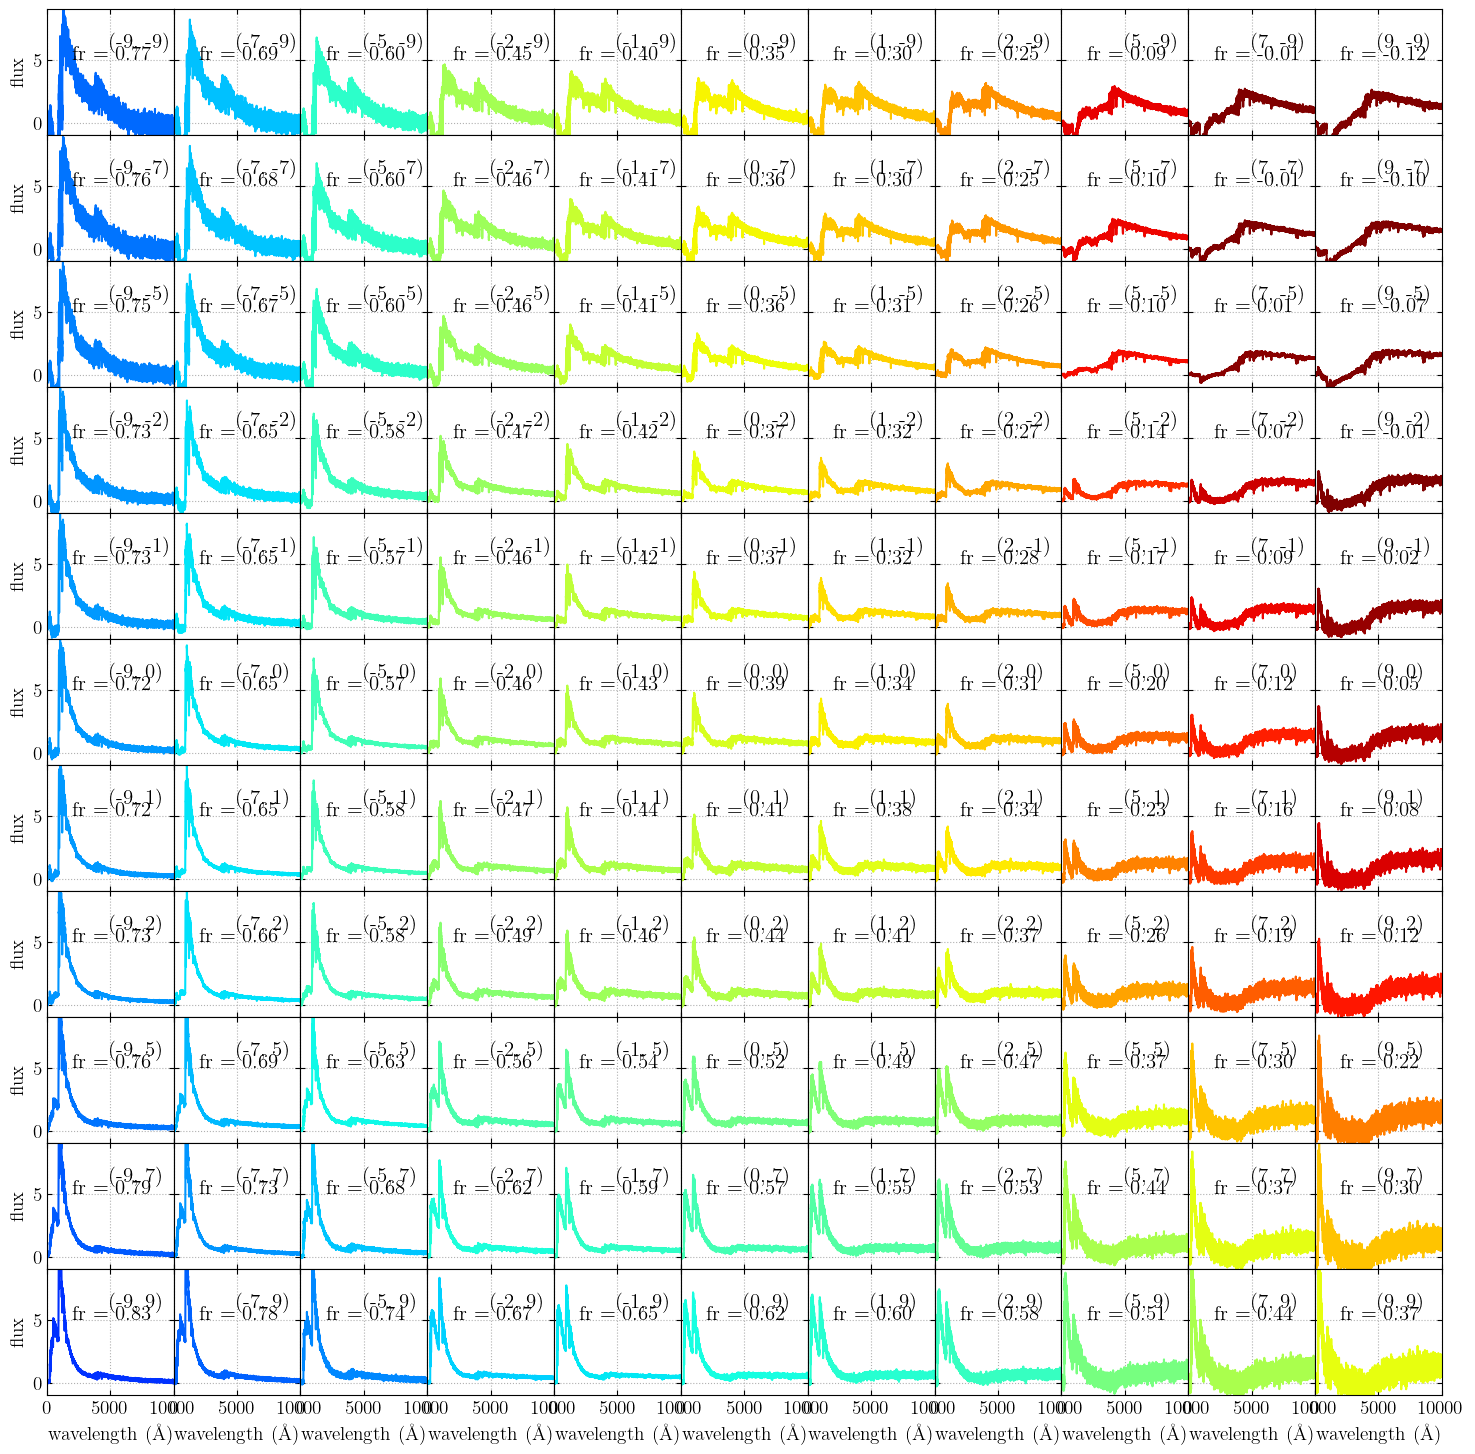

In [22]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-9,-7,-5,-2.,-1,0.,1,2.,5,7,9]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            
            #idx_fig = (2-j)*len(parvalues)+i+1
            idx_fig = j*len(parvalues)+i +1
            
        
            ax = fig.add_subplot(11, 11, idx_fig)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            #z[0, zorder] = z2, z1 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
           
            dspectrum = spectrum.numpy()[0,:]
            fullspectrum = meanspectrum+dspectrum
            
            flux_blue = fullspectrum[idx_blue]
            flux_red  = fullspectrum[idx_red]
            flux_integ=np.zeros(7)
            flux_integ[0] =  np.trapz(flux_blue ,wl_blue)
            flux_integ[1] =  np.trapz(flux_red ,wl_red)
            flux_integ[2] = flux_integ[0] + flux_integ[1] 
            flux_integ[3] = flux_integ[0] / flux_integ[2] 
            flux_integ[4] = flux_integ[1] / flux_integ[2] 
            flux_integ[5] = flux_integ[0] / flux_integ[1] 
            flux_integ[6] = flux_integ[1] / flux_integ[0] 
            
            color_spec = scalarMap.to_rgba(1-flux_integ[3], alpha=1)
    
            
            ax.plot(wavelengths,fullspectrum ,color=color_spec)
            ax.grid()
            ax.text(5000, 6, '(%i, %i)' % (z1,z2),fontsize=15)
            ax.text(2000, 5, f'fr = {flux_integ[3]:.2f}',fontsize=15)

            ax.set_xlim(0, 10000)
            ax.set_ylim(-1, 9)

            if i == 0:
                ax.set_ylabel('flux')
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == len(parvalues)-1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
#plt.tight_layout() 
plt.show()

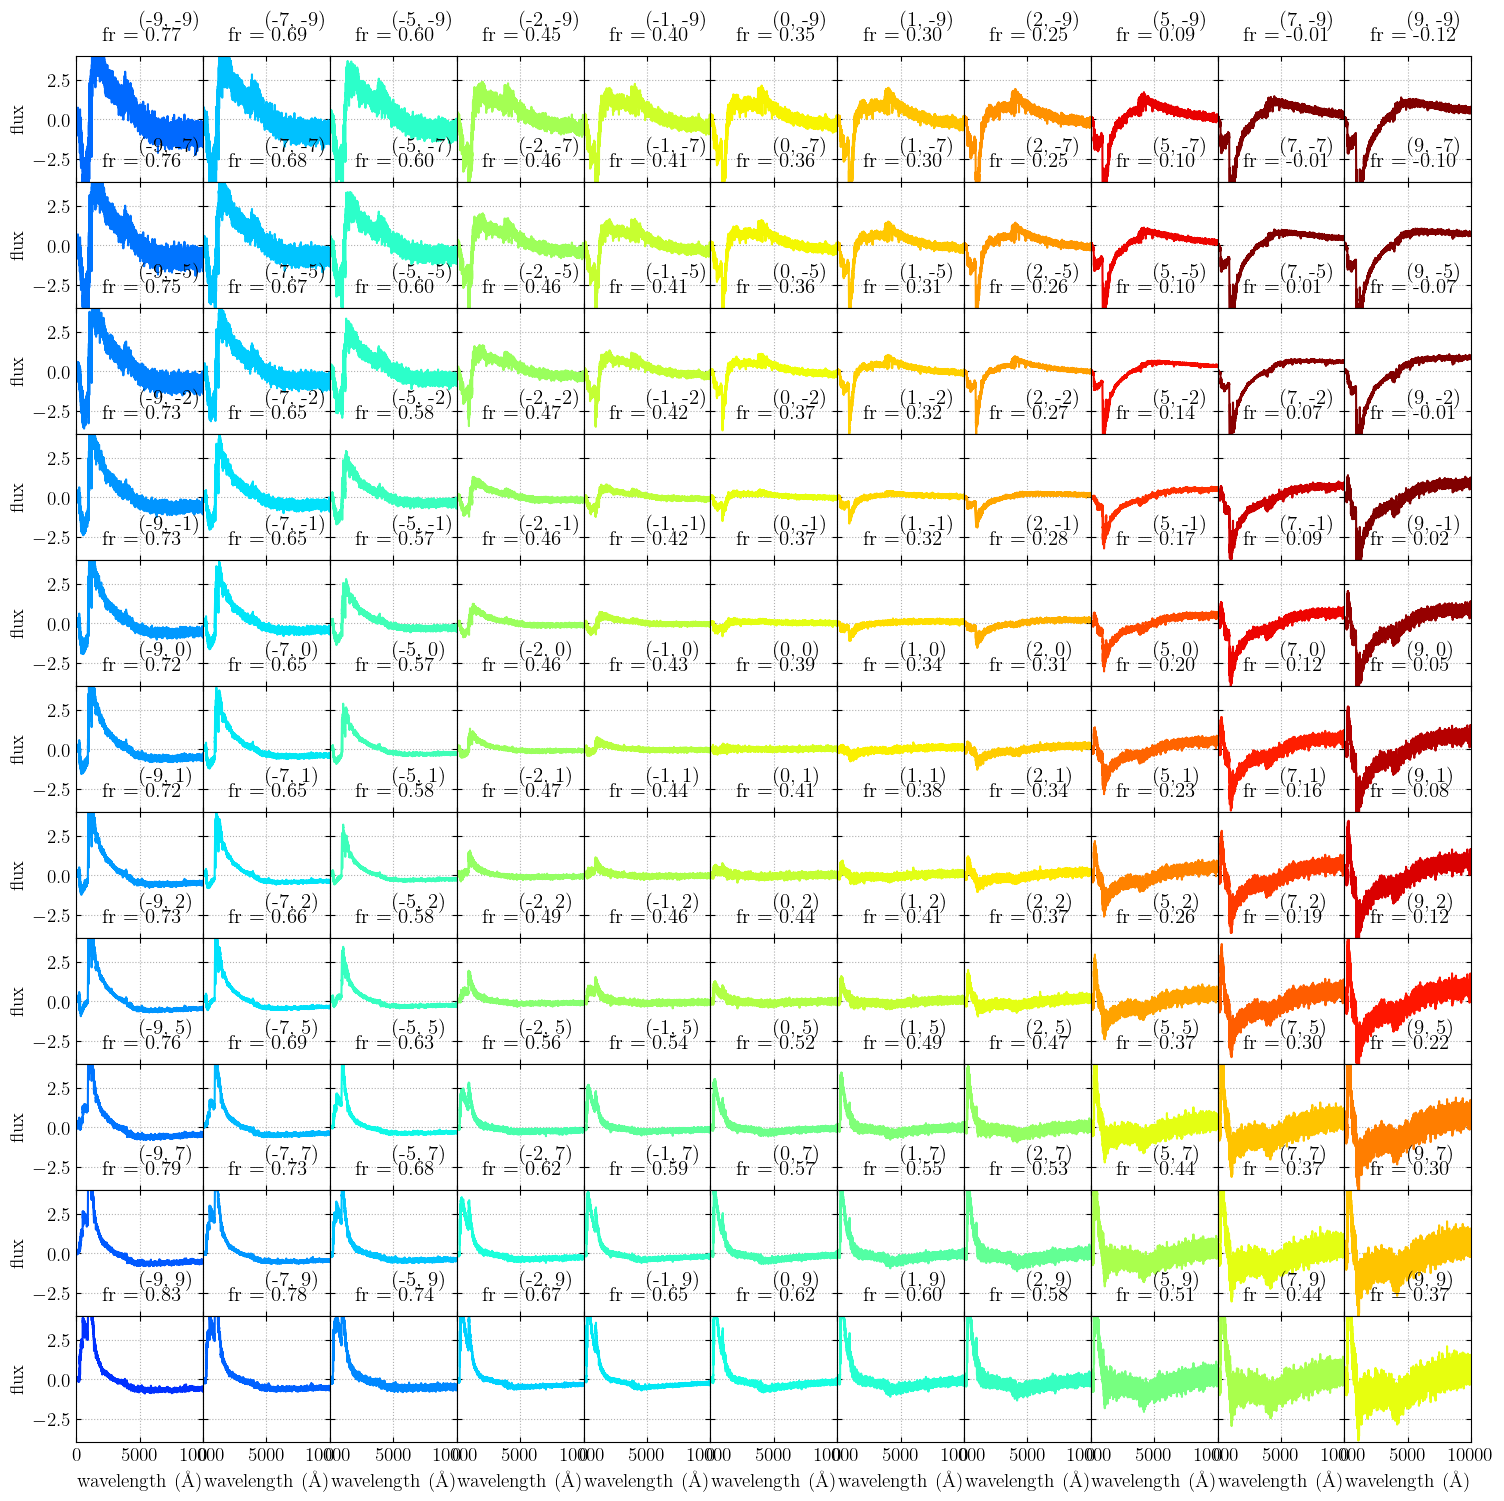

In [23]:
# plot results

with torch.no_grad():
    # sort latent parameters from most constrained to least constrained
    testspec = dataset[:][0]
    recon, mu, logvar = model(testspec)
    zorder = np.argsort(np.mean(logvar.numpy(), axis=0))

    fig = plt.figure(figsize=(18,18))
    fig.subplots_adjust(hspace=0, wspace=0)
    parvalues = [-9,-7,-5,-2.,-1,0.,1,2.,5,7,9]
    for i, z1 in enumerate(parvalues):
        for j, z2 in enumerate(parvalues):
            # get z1 to vary left to right, z2 bottom to top
            
            #idx_fig = (2-j)*len(parvalues)+i+1
            idx_fig = j*len(parvalues)+i +1
            
        
            ax = fig.add_subplot(11, 11, idx_fig)

            z = np.zeros((1,2), dtype=np.float32)
            z[0, zorder] = z1, z2 # set z1 is more constrained of the two latent parameters
            #z[0, zorder] = z2, z1 # set z1 is more constrained of the two latent parameters
            spectrum = model.decode(torch.tensor(z))
            dspectrum = spectrum.numpy()[0,:]
            fullspectrum = meanspectrum+dspectrum
            
            flux_blue = fullspectrum[idx_blue]
            flux_red  = fullspectrum[idx_red]
            flux_integ=np.zeros(7)
            flux_integ[0] =  np.trapz(flux_blue ,wl_blue)
            flux_integ[1] =  np.trapz(flux_red ,wl_red)
            flux_integ[2] = flux_integ[0] + flux_integ[1] 
            flux_integ[3] = flux_integ[0] / flux_integ[2] 
            flux_integ[4] = flux_integ[1] / flux_integ[2] 
            flux_integ[5] = flux_integ[0] / flux_integ[1] 
            flux_integ[6] = flux_integ[1] / flux_integ[0] 
            
            color_spec = scalarMap.to_rgba(1-flux_integ[3], alpha=1)
    
            
            ax.plot(wavelengths,dspectrum ,color=color_spec)
            ax.grid()
            ax.text(5000, 6, '(%i, %i)' % (z1,z2),fontsize=15)
            ax.text(2000, 5, f'fr = {flux_integ[3]:.2f}',fontsize=15)

            ax.set_xlim(0, 10000)
            ax.set_ylim(-4, 4)

            if i == 0:
                ax.set_ylabel('flux')
                ax.set_ylim(-4, 4)
            else:
                ax.yaxis.set_major_formatter(plt.NullFormatter())
            if j == len(parvalues)-1:
                ax.set_xlabel(r'${\rm wavelength\ (\AA)}$')
            else:
                ax.xaxis.set_major_formatter(plt.NullFormatter())
#plt.tight_layout()                
plt.show()

# Functions

In [24]:
def From2DLatentToSpectrum(model,z1,z2,zorder):
    z = np.zeros((1,2), dtype=np.float32)
    z[0, zorder] = z1, z2
    spectrum = model.decode(torch.tensor(z))
    
    dspectrum = spectrum.detach().numpy()[0,:]
    
    #dspectrum = spectrum.numpy()[0,:]
    fullspectrum = meanspectrum+dspectrum
    return fullspectrum

In [25]:
def FromSpectrumToColor(spectrum,lsst):
    
    sed = Sed(wavelen=WL/10.,flambda = spectrum)
    mags = {}
    for f in filterlist:
        mags[f] = sed.calc_mag(lsst[f])
        
    umg =  mags['u'] - mags['g']
    rmi =  mags['r'] - mags['i']
    
    return umg,rmi  

In [26]:
def FromZ1gridToColor(model,z1grid,z2,zorder,lsst):
    
    N1 = len(z1grid)
    umglist = np.zeros(N1)
    rmilist = np.zeros(N1)
    
    for idx,z1 in enumerate(z1grid):
        spectrum = From2DLatentToSpectrum(model,z1,z2,zorder)
        umglist[idx],rmilist[idx] = FromSpectrumToColor(spectrum,lsst) 
        
    return umglist,rmilist

In [27]:
def FromZ2gridToColor(model,z1,z2grid,zorder,lsst):
    
    N2 = len(z2grid)
    umglist = np.zeros(N2)
    rmilist = np.zeros(N2)
    
    for idx,z2 in enumerate(z2grid):
        spectrum = From2DLatentToSpectrum(model,z1,z2,zorder)
        umglist[idx],rmilist[idx] = FromSpectrumToColor(spectrum,lsst) 
        
    return umglist,rmilist

# Rubin sim

In [28]:
# Find the throughputs directory 
fdir = os.getenv('RUBIN_SIM_DATA_DIR')
if fdir is None:  #environment variable not set
    fdir = os.path.join(os.getenv('HOME'), 'rubin_sim_data')

fdir = os.path.join(fdir, 'throughputs', 'baseline')


In [29]:
# Read the throughput curves
filterlist = ['u', 'g', 'r', 'i', 'z', 'y']

lsst = {}
for f in filterlist:
    lsst[f] = Bandpass()
    lsst[f].read_throughput(os.path.join(fdir, f'filter_{f}.dat'))

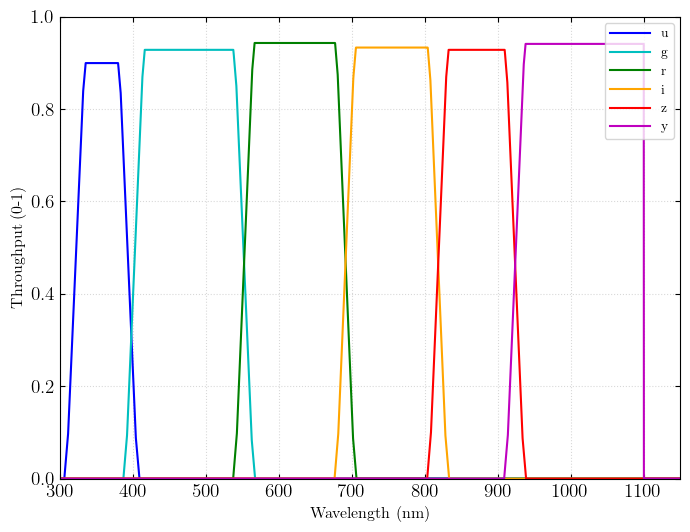

In [30]:
# Plot the curves .. see what we have. 
filtercolors = {'u':'b', 'g':'c', 'r':'g', 'i':'orange', 'z':'r', 'y':'m'}

plt.figure(figsize=(8,6))
for f in filterlist:
    plt.plot(lsst[f].wavelen, lsst[f].sb, color=filtercolors[f], label=f)
plt.xlabel("Wavelength (nm)", fontsize='x-large')
plt.ylabel("Throughput (0-1)", fontsize='x-large')
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, color='gray')
plt.legend(loc='upper right', fancybox=True, fontsize='large')


In [31]:
NSED = renormedspectra.shape[0]
NSED

550

### Redshift 0

In [32]:
df = pd.DataFrame(columns=['name', 'frac','u', 'g','r','i','z','y'])

In [33]:
all_colors = []
for idx in range(NSED):
    num=number[idx]
    name = f'SL_FORS{num:d}'
    frac = fracinfbalmer[idx]
    color_spec = scalarMap.to_rgba(frac, alpha=1)
    all_colors.append(color_spec)
    sed = Sed(wavelen=wavelengths/10.,flambda = renormedspectra[idx,:],name=name)
    mags = {}
    for f in filterlist:
        mags[f] = sed.calc_mag(lsst[f])
    #print(mags)
    df.loc[idx] = [sed.name, frac] + [ mags[f] for f in filterlist]
    

In [34]:
df.head()

,name,frac,u,g,r,i,z,y
0,SL_FORS2,0.212012,-16.983463,-18.371056,-19.068970,-19.497272,-19.744903,-20.091488
1,SL_FORS3,0.243344,-17.774299,-18.852547,-19.163746,-19.333848,-19.427534,-19.576303
2,SL_FORS9,0.100771,-17.066713,-18.585644,-19.289269,-19.671722,-19.877950,-20.149672
3,SL_FORS13,0.803801,-17.540958,-17.571569,-17.426752,-17.543789,-17.714124,-17.974010
4,SL_FORS19,0.230531,-17.386405,-18.576685,-19.060727,-19.404317,-19.618248,-19.937879


In [35]:
df["u-g"] = df["u"]-df["g"]
df["r-i"] = df["r"]-df["i"]

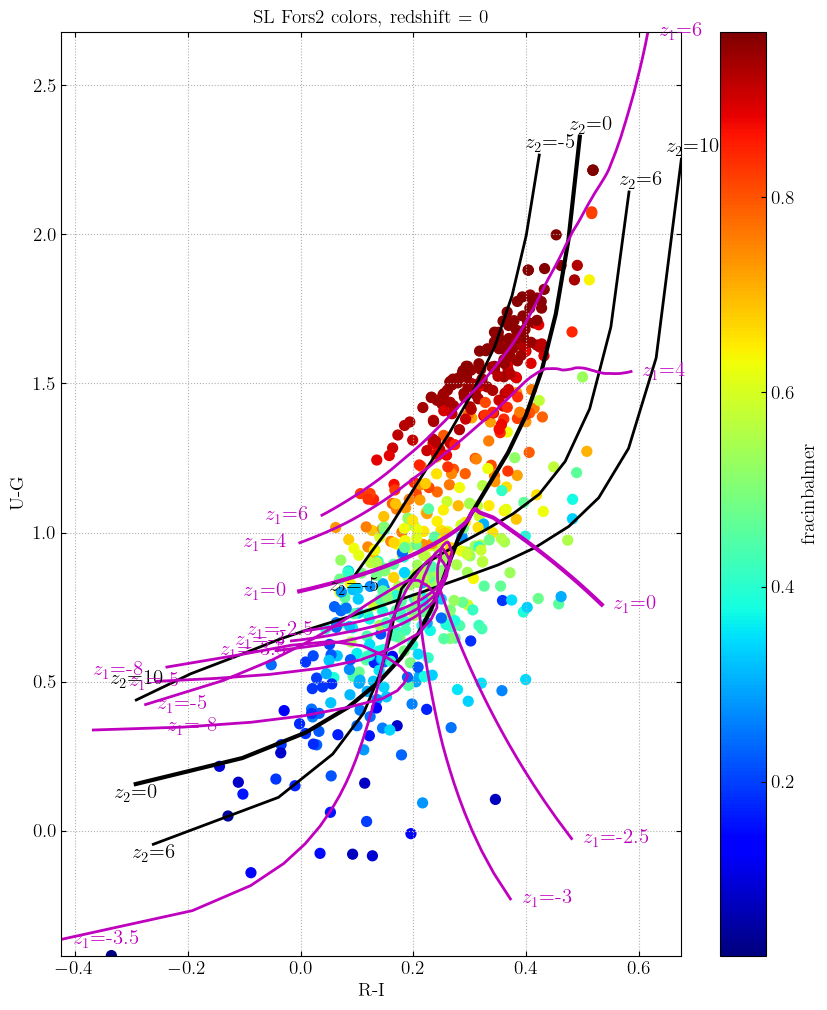

In [36]:
fig=plt.figure(figsize=(10,12))
ax=fig.add_subplot(1,1,1)
#im=ax.scatter(df["r-i"].values,df["u-g"],c=all_colors, edgecolors='face',marker="o" ,s=50,cmap=jet)
im=ax.scatter(df["r-i"].values,df["u-g"],c=1-fracinfbalmer, edgecolors='face',marker="o" ,s=50,cmap=jet)
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('fracinbalmer')   
ax.set_xlabel("R-I")
ax.set_ylabel("U-G")
ax.grid()
title = "SL Fors2 colors, redshift = 0"
ax.set_title(title)


## Z1 lines
###########
z1grid = np.arange(-11,8,1)
z2 = 0
Y,X = FromZ1gridToColor(model,z1grid,z2,zorder,lsst)
ax.plot(X,Y,'k-',lw=3)
label = f'$z_2$={z2}'
ax.text(X[0],Y[0]-0.05, label,fontsize=15,horizontalalignment='center')
ax.text(X[-1]+0.02,Y[-1]+0.02, label,fontsize=15,horizontalalignment='center')
##
z1grid = np.arange(-12.5,6.2,1)
z2 = 6
Y,X = FromZ1gridToColor(model,z1grid,z2,zorder,lsst)
ax.plot(X,Y,'k-',lw=2)
label = f'$z_2$={z2}'
ax.text(X[0],Y[0]-0.05, label,fontsize=15,horizontalalignment='center')
ax.text(X[-1]+0.02,Y[-1]+0.02, label,fontsize=15,horizontalalignment='center')


##
z1grid = np.arange(0,11,1)
z2 = -5
Y,X = FromZ1gridToColor(model,z1grid,z2,zorder,lsst)
ax.plot(X,Y,'k-',lw=2)
label = f'$z_2$={z2}'
ax.text(X[0],Y[0]-0.05, label,fontsize=15,horizontalalignment='center')
ax.text(X[-1]+0.02,Y[-1]+0.02, label,fontsize=15,horizontalalignment='center')

#z2grid = np.arange(-6,9,0.2)
#z1 = -6
#Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
#ax.plot(X,Y,'m-',lw=2)
#label = f'$z_1$={z1}'
#ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
#ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##


##
z1grid = np.arange(-10,6,1)
z2=10
Y,X = FromZ1gridToColor(model,z1grid,z2,zorder,lsst)
ax.plot(X,Y,'k-',lw=2)
label = f'$z_2$={z2}'
ax.text(X[0],Y[0]+0.05, label,fontsize=15,horizontalalignment='center')
ax.text(X[-1]+0.02,Y[-1]+0.02, label,fontsize=15,horizontalalignment='center')
##

##################################

## Z2 lines
#############################
z2grid = np.arange(-7,14,0.2)
z1 = 0
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=3)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##


z2grid = np.arange(-6,16,1)
z1 = -5
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.05,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##

z2grid = np.arange(-4,12,1)
z1 = -8
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0],Y[0]+0.2, label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1],Y[-1]-0.2, label,fontsize=15,verticalalignment='center',color='m')
##

z2grid = np.arange(-11,8.5,0.2)
z1 = 4
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##

z2grid = np.arange(-12,7,0.2)
z1 = 6
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##


z2grid = np.arange(-5,18,0.2)
z1 = -2.5
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##

z2grid = np.arange(-5,18.5,0.2)
z1 = -3
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##

z2grid = np.arange(-5,19,0.2)
z1 = -3.5
Y,X = FromZ2gridToColor(model,z1,z2grid,zorder,lsst)
ax.plot(X,Y,'m-',lw=2)
label = f'$z_1$={z1}'
ax.text(X[0]-0.1,Y[0], label,fontsize=15,verticalalignment='center',color="m")
ax.text(X[-1]+0.02,Y[-1], label,fontsize=15,verticalalignment='center',color='m')
##


plt.show()


### Redshift 0.5

In [37]:
redshift=0.5
df = pd.DataFrame(columns=['name', 'frac','u', 'g','r','i','z','y'])

In [38]:
all_colors = []
for idx in range(NSED):
    num=number[idx]
    name = f'SL_FORS{num:d}'
    frac = fracinfbalmer[idx]
    color_spec = scalarMap.to_rgba(frac, alpha=1)
    all_colors.append(color_spec)
    sed = Sed(wavelen=wavelengths/10.,flambda = renormedspectra[idx,:],name=name)
    sed.redshift_sed(redshift)
    mags = {}
    for f in filterlist:
        mags[f] = sed.calc_mag(lsst[f])
    #print(mags)
    df.loc[idx] = [sed.name, frac] + [ mags[f] for f in filterlist]
    

In [39]:
df["u-g"] = df["u"]-df["g"]
df["r-i"] = df["r"]-df["i"]

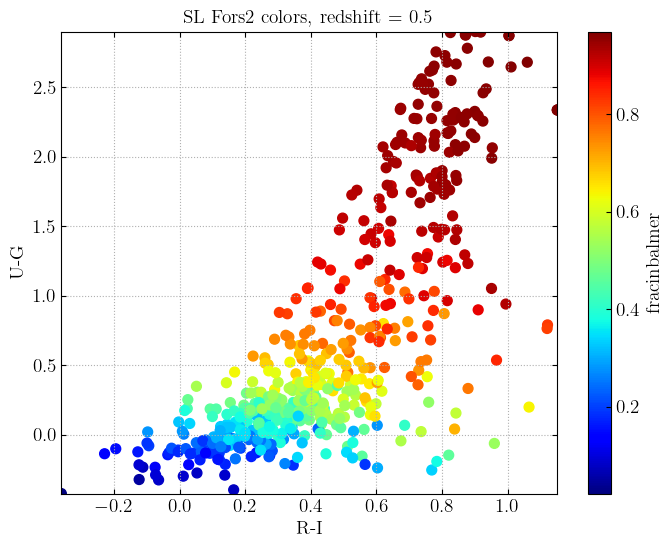

In [40]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
#im=ax.scatter(df["r-i"].values,df["u-g"],c=all_colors, edgecolors='face',marker="o" ,s=50,cmap=jet)
im=ax.scatter(df["r-i"].values,df["u-g"],c=1-fracinfbalmer, edgecolors='face',marker="o" ,s=50,cmap=jet)
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('fracinbalmer')   
ax.set_xlabel("R-I")
ax.set_ylabel("U-G")
ax.grid()
title = f"SL Fors2 colors, redshift = {redshift}"
ax.set_title(title)
plt.show()

### Redshift 1

In [41]:
redshift=1.0
df = pd.DataFrame(columns=['name', 'frac','u', 'g','r','i','z','y'])

In [42]:
all_colors = []
for idx in range(NSED):
    num=number[idx]
    name = f'SL_FORS{num:d}'
    frac = fracinfbalmer[idx]
    color_spec = scalarMap.to_rgba(frac, alpha=1)
    all_colors.append(color_spec)
    sed = Sed(wavelen=wavelengths/10.,flambda = renormedspectra[idx,:],name=name)
    sed.redshift_sed(redshift)
    mags = {}
    for f in filterlist:
        mags[f] = sed.calc_mag(lsst[f])
    #print(mags)
    df.loc[idx] = [sed.name, frac] + [ mags[f] for f in filterlist]
    

In [43]:
df["u-g"] = df["u"]-df["g"]
df["r-i"] = df["r"]-df["i"]

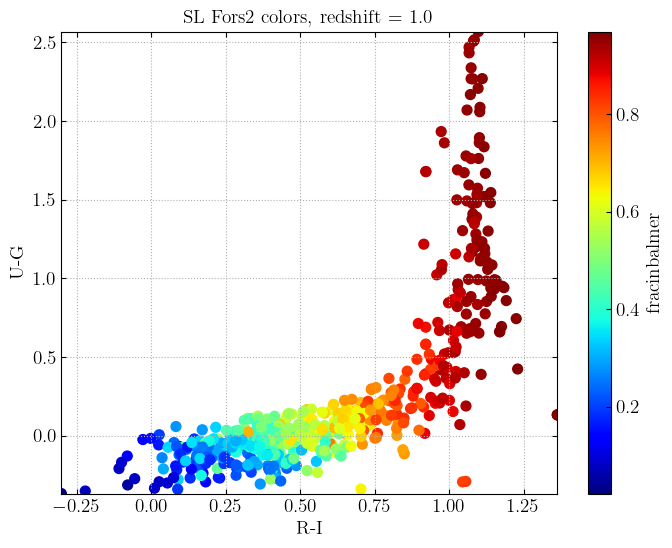

In [44]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
#im=ax.scatter(df["r-i"].values,df["u-g"],c=all_colors, edgecolors='face',marker="o" ,s=50,cmap=jet)
im=ax.scatter(df["r-i"].values,df["u-g"],c=1-fracinfbalmer, edgecolors='face',marker="o" ,s=50,cmap=jet)
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('fracinbalmer')   
ax.set_xlabel("R-I")
ax.set_ylabel("U-G")
ax.grid()
title = f"SL Fors2 colors, redshift = {redshift}"
ax.set_title(title)
plt.show()

In [45]:
redshift=2.0
df = pd.DataFrame(columns=['name', 'frac','u', 'g','r','i','z','y'])

In [46]:
all_colors = []
for idx in range(NSED):
    num=number[idx]
    name = f'SL_FORS{num:d}'
    frac = fracinfbalmer[idx]
    color_spec = scalarMap.to_rgba(frac, alpha=1)
    all_colors.append(color_spec)
    sed = Sed(wavelen=wavelengths/10.,flambda = renormedspectra[idx,:],name=name)
    sed.redshift_sed(redshift)
    mags = {}
    for f in filterlist:
        mags[f] = sed.calc_mag(lsst[f])
    #print(mags)
    df.loc[idx] = [sed.name, frac] + [ mags[f] for f in filterlist]
    

In [47]:
df["u-g"] = df["u"]-df["g"]
df["r-i"] = df["r"]-df["i"]

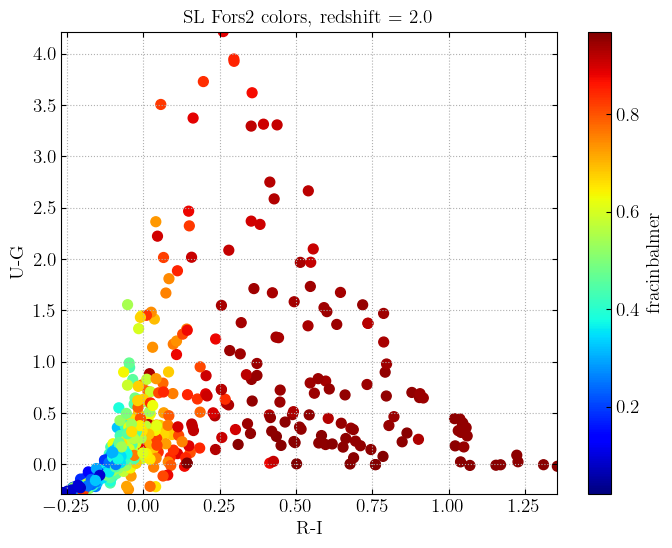

In [48]:
fig=plt.figure(figsize=(8,6))
ax=fig.add_subplot(1,1,1)
#im=ax.scatter(df["r-i"].values,df["u-g"],c=all_colors, edgecolors='face',marker="o" ,s=50,cmap=jet)
im=ax.scatter(df["r-i"].values,df["u-g"],c=1-fracinfbalmer, edgecolors='face',marker="o" ,s=50,cmap=jet)
cbar = plt.colorbar(im,ax=ax)
cbar.set_label('fracinbalmer')   
ax.set_xlabel("R-I")
ax.set_ylabel("U-G")
ax.grid()
title = f"SL Fors2 colors, redshift = {redshift}"
ax.set_title(title)
plt.show()